In [1]:
import numpy as np
import scipy
import struct
import os
from sklearn.neighbors import KNeighborsClassifier
from matplotlib.pylab import plt
import statistics
import math

In [2]:
path = "./mnist_data/"
def read(dataset = "training", datatype='images'):
    """
    Python function for importing the MNIST data set. It returns an iterator
    of 2-tuples with the first element being the label and the second element
    being a numpy.uint8 2D array of pixel data for the given image.
    """
    if dataset is "training":
        fname_img = os.path.join(path, 'train-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 'train-labels-idx1-ubyte')
    elif dataset is "testing":
        fname_img = os.path.join(path, 't10k-images-idx3-ubyte')
        fname_lbl = os.path.join(path, 't10k-labels-idx1-ubyte')
        
    # Load everything in some numpy arrays
    with open(fname_lbl, 'rb') as flbl:
        magic, num = struct.unpack(">II", flbl.read(8))
        lbl = np.fromfile(flbl, dtype=np.int8)
    with open(fname_img, 'rb') as fimg:
        magic, num, rows, cols = struct.unpack(">IIII", fimg.read(16))
        img = np.fromfile(fimg, dtype=np.uint8).reshape(len(lbl), rows, cols)
    if(datatype=='images'):
        get_data = lambda idx: img[idx]
    elif(datatype=='labels'):
        get_data = lambda idx: lbl[idx]
    # Create an iterator which returns each image in turn
    for i in range(len(lbl)):
        yield get_data(i)
        
trainData=np.array(list(read('training','images')))
trainLabels=np.array(list(read('training','labels')))
testData=np.array(list(read('testing','images')))
testLabels=np.array(list(read('testing','labels')))

# Make data 2D
trainData = trainData.reshape(trainData.shape[0], -1)
testData = testData.reshape(testData.shape[0], -1)
# Make labels 2D
#trainLabels = trainLabels.reshape(trainLabels.shape[0], -1)
#testLabels = testLabels.reshape(testLabels.shape[0], -1)

In [ ]:
# Baseline, 1-NN overall all the dataset
neigh = KNeighborsClassifier(n_neighbors=1)
neigh.fit(trainData, trainLabels) 
print("Baseline score on 1-NN using all data:{}".format(neigh.score(testData, testLabels)))

In [3]:
def choose_random_samples_per_class(X, y, M):
    prots_s = []
    labels_s = []

    classes = np.unique(y)
    sample_per_class = M // len(classes)

    # Adding one sample from each class
    for cur_class in classes:
        mask = y == cur_class
        insts = X[mask]
        prots_s = prots_s + [insts[np.random.randint(0, insts.shape[0], size=sample_per_class)]]
        labels_s = labels_s + [cur_class] * sample_per_class
        
    return np.asarray(prots_s).reshape(-1, 784), np.asarray(labels_s)

In [4]:
def choose_random_samples(X, y, M):
    
    #indexes = np.random.randint(0, X.shape[0], size=M, seed=42)
    indexes = np.random.choice(X.shape[0], size=M, replace=False)
    prots_s = X[indexes]
    labels_s = y[indexes]
        
    return np.asarray(prots_s).reshape(-1, 784), np.asarray(labels_s)

In [5]:
# Nearest Neighbor
p = np.random.permutation(trainData.shape[0])
trainData = trainData[p]
trainLabels = trainLabels[p]
print("number of samples:{}".format(trainData.shape[0]))

number of samples:60000


In [18]:
# Imbalance the dataset
classes = np.unique(trainLabels)
b = np.random.uniform(0.30,0.7, 5)
# print(a)
sample_subsets = []
target_subsets = []
for cur_class in range(5):
    mask = trainLabels == cur_class
    insts = trainData[mask]
    a = np.random.randint(0, insts.shape[0], (int)(insts.shape[0]*(b[cur_class])))
    sample_subsets.append(insts[a])
    target_subsets.append(trainLabels[mask][a])

for cur_class in range(5, 10):
    mask = trainLabels == cur_class
    insts = trainData[mask]
    sample_subsets.append(insts)
    target_subsets.append(trainLabels[mask])
    
# permutations
X_ = np.asarray(sample_subsets)
y_ = np.asarray(target_subsets)
X = X_[0]
y = [0] * len(X_[0])
for i in range(1, 10):
    X = np.concatenate((X, X_[i]), axis=0)
    y += [i] * len(X_[i])
    
y = np.asarray(y)

for _ in range(10):
    a = np.random.permutation(X.shape[0])
    X = X[a]
    y = y[a]
    
trainData = X
trainLabels = y
print("number of samples:{}".format(trainData.shape[0]))

number of samples:46465


In [6]:
acc = []
for _ in range(100):
    neigh = KNeighborsClassifier(n_neighbors=1)
    ProtoData, ProtoLabels = choose_random_samples(trainData, trainLabels, 100)
    neigh.fit(ProtoData, ProtoLabels) 
    acc.append(neigh.score(testData, testLabels))

print("Number of prototype samples:{}".format(ProtoData.shape[0]))
mean = statistics.mean(acc)
std = statistics.stdev(acc)
error = (1.96 * std)/ math.sqrt(len(acc))

print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
print("Error at confidence of 95%: {}".format(error))

Number of prototype samples:100
Mean accuracy:0.708097, Standard Deviation:0.019391195831035685
Error at confidence of 95%: 0.0038006743828829944


In [7]:
# Nearest Neighbor
acc_500 = []
for _ in range(100):
    neigh = KNeighborsClassifier(n_neighbors=1)
    ProtoData, ProtoLabels = choose_random_samples(trainData, trainLabels, 500)
    neigh.fit(ProtoData, ProtoLabels) 
    acc_500.append(neigh.score(testData, testLabels))

print("Number of prototype samples:{}".format(ProtoData.shape[0]))
mean = statistics.mean(acc_500)
std = statistics.stdev(acc_500)
error = (1.96 * std)/ math.sqrt(len(acc_500))

print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
print("Error at confidence of 95%: {}".format(error))

Number of prototype samples:500
Mean accuracy:0.849601, Standard Deviation:0.0062482885737624285
Error at confidence of 95%: 0.001224664560457436


In [8]:
# Nearest Neighbor
acc_1000 = []
for _ in range(100):
    neigh = KNeighborsClassifier(n_neighbors=1)
    ProtoData, ProtoLabels = choose_random_samples(trainData, trainLabels, 1000)
    neigh.fit(ProtoData, ProtoLabels)
    acc_1000.append(neigh.score(testData, testLabels))
    
print("Number of prototype samples:{}".format(ProtoData.shape[0]))
mean = statistics.mean(acc_1000)
std = statistics.stdev(acc_1000)
error = (1.96 * std)/ math.sqrt(len(acc_1000))

print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
print("Error at confidence of 95%: {}".format(error))

Number of prototype samples:1000
Mean accuracy:0.884519, Standard Deviation:0.004557216388555768
Error at confidence of 95%: 0.0008932144121569305


In [9]:
# Nearest Neighbor
acc_5000 = []
for _ in range(100):
    neigh = KNeighborsClassifier(n_neighbors=1)
    ProtoData, ProtoLabels = choose_random_samples(trainData, trainLabels, 5000)
    neigh.fit(ProtoData, ProtoLabels)
    acc_5000.append(neigh.score(testData, testLabels))

print("Number of prototype samples:{}".format(ProtoData.shape[0]))
mean = statistics.mean(acc_5000)
std = statistics.stdev(acc_5000)
error = (1.96 * std)/ math.sqrt(len(acc_5000))

print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
print("Error at confidence of 95%: {}".format(error))

Number of prototype samples:5000
Mean accuracy:0.935385, Standard Deviation:0.0018742473236750298
Error at confidence of 95%: 0.0003673524754403058


In [10]:
# Nearest Neighbor
acc_10000 = []
for _ in range(100):
    neigh = KNeighborsClassifier(n_neighbors=1)
    ProtoData, ProtoLabels = choose_random_samples(trainData, trainLabels, 10000)
    neigh.fit(ProtoData, ProtoLabels) 
    acc_10000.append(neigh.score(testData, testLabels))

print("Number of prototype samples:{}".format(ProtoData.shape[0]))
mean = statistics.mean(acc_10000)
std = statistics.stdev(acc_10000)
error = (1.96 * std)/ math.sqrt(len(acc_10000))

print("Mean accuracy:{}, Standard Deviation:{}".format(mean, std))
print("Error at confidence of 95%: {}".format(error))

Number of prototype samples:10000
Mean accuracy:0.948491, Standard Deviation:0.001910475904537438
Error at confidence of 95%: 0.00037445327728933783


In [71]:
acc_500_100 = [round(a*100) for a in acc_500] 

In [77]:
data = {}
for a in acc_500_100:
    if a not in data:
        data[a] = 1
    else:
        data[a] += 1

In [78]:
data

{86.0: 25, 84.0: 28, 85.0: 46, 83.0: 1}

/home/amanraj/anaconda3/envs/neural/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6571: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


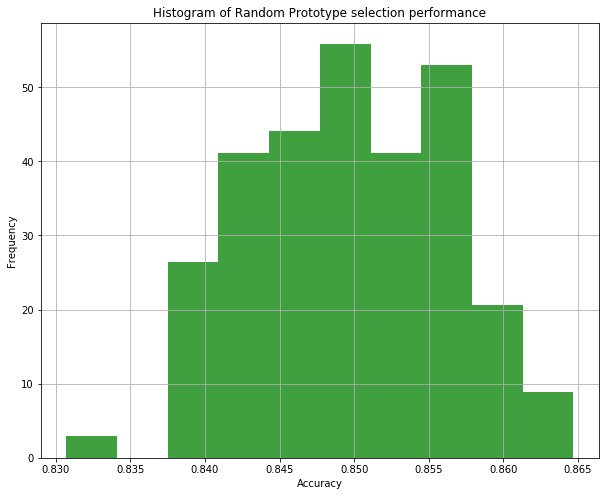

In [107]:
import numpy as np
import matplotlib.mlab as mlab
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))

# the histogram of the data
n, bins, patches = plt.hist(acc_500, normed=1, facecolor='green', alpha=0.75)

plt.xlabel('Accuracy')
plt.ylabel('Frequency')
plt.title('Histogram of Random Prototype selection performance')
plt.grid(True)

plt.show()